In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
import time
import dill
from PIL import Image
from collections import defaultdict
import pyamg
from os import listdir
from os.path import isfile, join

In [3]:
def get_maximum(A):
    init = A[0]
    for a in A[1:]:
        init = np.maximum(a, init)
    return init

In [4]:
folder = './img_k/'
imgs_files = [f for f in listdir(folder) if isfile(join(folder, f))]
imgs_files

['IMG_20200613_014119.jpg',
 'IMG_20200613_014128.jpg',
 'IMG_20200613_014132.jpg',
 'IMG_20200613_014144.jpg']

In [5]:
imgs = []
for img in imgs_files:
#     imgs.append(cv2.imread(folder + img))
    imgs.append(cv2.cvtColor(cv2.imread(folder + img), cv2.COLOR_BGR2RGB))


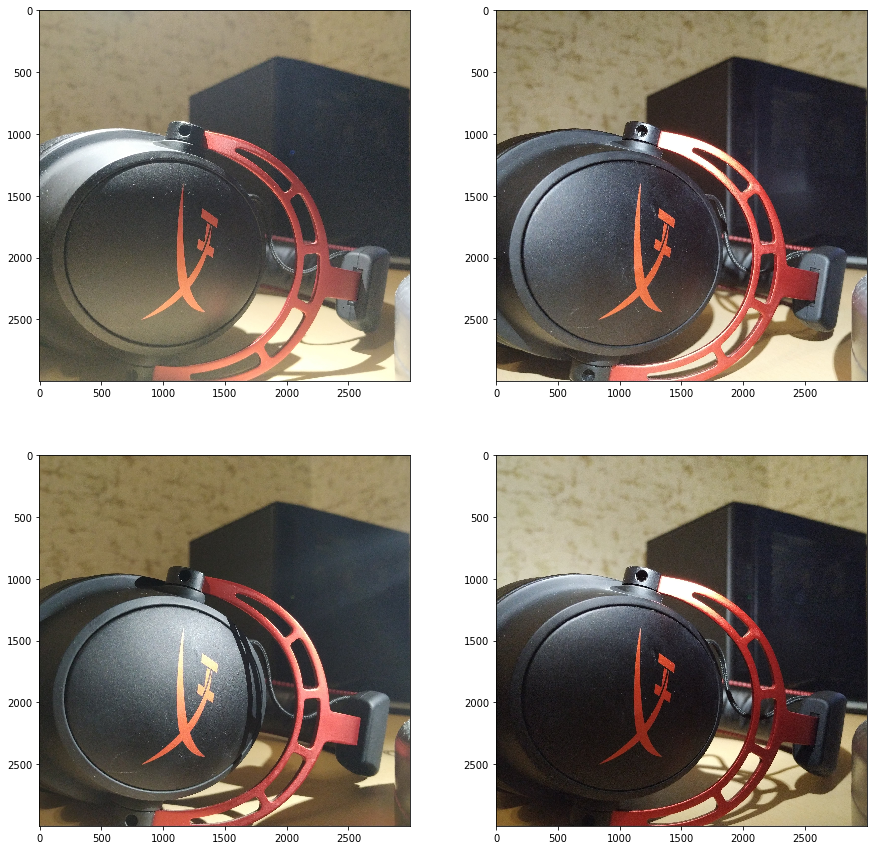

In [6]:
f, axarr = plt.subplots(2,2, figsize=(15,15))
axarr[0,0].imshow(imgs[0])
axarr[0,1].imshow(imgs[1])
axarr[1,0].imshow(imgs[2])
axarr[1,1].imshow(imgs[3])

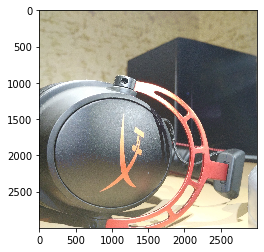

In [7]:
I_colors = defaultdict(list)
for I_k in imgs:
    I = cv2.split(I_k)
    for color, value in enumerate(I):
        I_colors[color].append(value)

max_vals = []
for color in range(3):
    max_v = I_colors[color][0]
    for value in I_colors[color][1:]:
        max_v = np.maximum(max_v, value)
    max_vals.append(max_v)

I_max = cv2.merge(max_vals)
plt.imshow(I_max)

mb sobel

In [8]:
def stats(A):
    return A.dtype, A.shape, np.min(A), np.median(A), np.max(A)

## Calculate intensity gradients $G_k$ gradients of $I_k$. Sobel and numpy

In [54]:
def sobel_filter(image, flag):
    result = []
    colors = cv2.split(image)
    for c in colors:
        color = c
#         color = cv2.cvtColor(c, cv2.COLOR_RGB2GRAY)
#         color = cv2.GaussianBlur(c, (7, 7), 0)
        if flag:
            color = cv2.Sobel(color, cv2.CV_64F, 1, 0, ksize=5)
        else:
            color = cv2.Sobel(color, cv2.CV_64F, 0, 1, ksize=5)
        result.append(color)
    
    
    return cv2.merge(result)

In [55]:
G_sobel_x = []
G_sobel_y = []
G_np_x = []
G_np_y = []
# G = []
for circle in imgs:
    
#     sobelx = cv2.Sobel(circle,cv2.CV_64F,1,0,ksize=5)
#     sobely = cv2.Sobel(circle,cv2.CV_64F,0,1,ksize=5)
    
    sobelx = sobel_filter(circle, True)
    sobely = sobel_filter(circle, False)
    
    G_sobel_x.append(sobelx)
    G_sobel_y.append(sobely)
    
    print(f"stats X: {stats(sobelx)}")
    print(f"stats Y: {stats(sobely)}")
    
    print("=" * 20)
   
    g_y, g_x, g_z = np.gradient(circle)
    G_np_x.append(g_x)
    G_np_y.append(g_y)    
    
    print(f"g_x : {stats(g_x)}")
    print(f"g_y : {stats(g_y)}")
    
    print("-" * 20)
    



stats X: (dtype('float64'), (3000, 3000, 3), -9052.0, 0.0, 6866.0)
stats Y: (dtype('float64'), (3000, 3000, 3), -8376.0, 0.0, 7801.0)
g_x : (dtype('float64'), (3000, 3000, 3), -105.0, 0.0, 79.0)
g_y : (dtype('float64'), (3000, 3000, 3), -89.5, 0.0, 79.5)
--------------------
stats X: (dtype('float64'), (3000, 3000, 3), -9913.0, -1.0, 8872.0)
stats Y: (dtype('float64'), (3000, 3000, 3), -10367.0, 0.0, 8274.0)
g_x : (dtype('float64'), (3000, 3000, 3), -107.0, 0.0, 108.0)
g_y : (dtype('float64'), (3000, 3000, 3), -106.5, 0.0, 89.0)
--------------------
stats X: (dtype('float64'), (3000, 3000, 3), -9298.0, 2.0, 7378.0)
stats Y: (dtype('float64'), (3000, 3000, 3), -8563.0, -2.0, 8558.0)
g_x : (dtype('float64'), (3000, 3000, 3), -102.5, 0.0, 85.5)
g_y : (dtype('float64'), (3000, 3000, 3), -99.0, 0.0, 88.0)
--------------------
stats X: (dtype('float64'), (3000, 3000, 3), -9456.0, -1.0, 8652.0)
stats Y: (dtype('float64'), (3000, 3000, 3), -9878.0, -2.0, 8948.0)
g_x : (dtype('float64'), (3000,

## $G$ median of gradients ($G(x, y)= median_{k} (G_k(x,y))$). Sobel and numpy

In [56]:
G_sobel_median_x = np.median(G_sobel_x, axis=0)
G_sobel_median_y = np.median(G_sobel_y, axis=0)

G_np_median_x = np.median(G_np_x, axis=0)
G_np_median_y = np.median(G_np_y, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


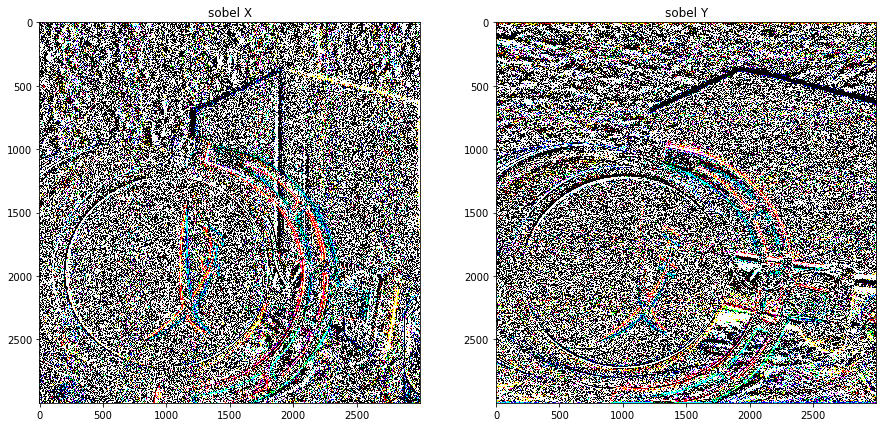

In [57]:
f, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].set_title("sobel X")
ax[1].set_title("sobel Y")

ax[0].imshow(G_sobel_median_x)
ax[1].imshow(G_sobel_median_y)

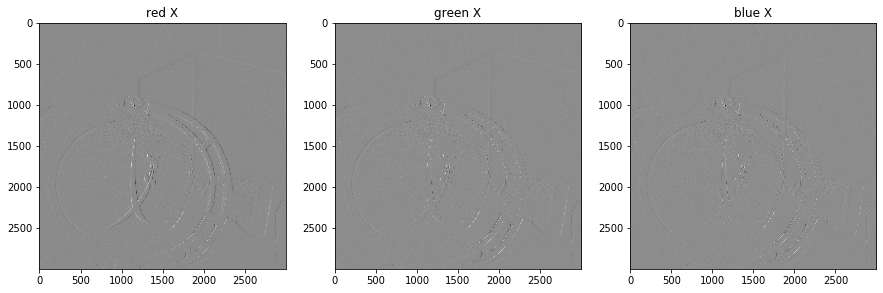

In [58]:
f, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].set_title("red X")
ax[1].set_title("green X")
ax[2].set_title("blue X")

for i, color in enumerate(cv2.split(G_sobel_median_x)):
    ax[i].imshow(color, cmap='gray')


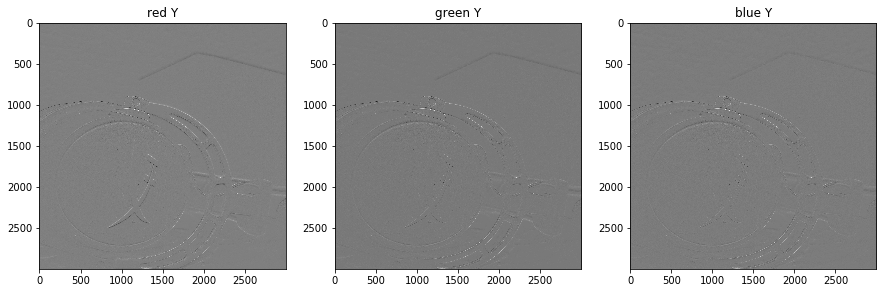

In [59]:
f, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].set_title("red Y")
ax[1].set_title("green Y")
ax[2].set_title("blue Y")

for i, color in enumerate(cv2.split(G_sobel_median_y)):
    ax[i].imshow(color, cmap='gray')

In [16]:
print(f"sobel_x median: {stats(G_sobel_median_x)}")
print(f"numpy_x median: {stats(G_np_median_x)}")

sobel_x median: (dtype('float64'), (3000, 3000), -4650.5, -0.5, 3670.0)
numpy_x median: (dtype('float64'), (3000, 3000, 3), -79.5, 0.0, 73.0)


## Poisson equation

### divergence of the vector field G

In [60]:
# sobelx = cv2.Sobel(G_sobel_median_x, cv2.CV_64F,1,0,ksize=5)
# sobely = cv2.Sobel(G_sobel_median_y, cv2.CV_64F,0,1,ksize=5)

sobelx = sobel_filter(G_sobel_median_x, True)
sobely = sobel_filter(G_sobel_median_y, False)

div_G_sobel = sobelx + sobely

x_y, x_x, x_z = np.gradient(G_np_median_x)
y_y, y_x, y_z = np.gradient(G_np_median_y)
div_G_np = x_x + y_y

In [61]:
print(f"div_G_sobel: {stats(div_G_sobel)}")
print(f"div_G_np: {stats(div_G_np)}")

div_G_sobel: (dtype('float64'), (3000, 3000, 3), -546288.5, 58.5, 452979.0)
div_G_np: (dtype('float64'), (3000, 3000, 3), -77.5, 0.0, 62.375)


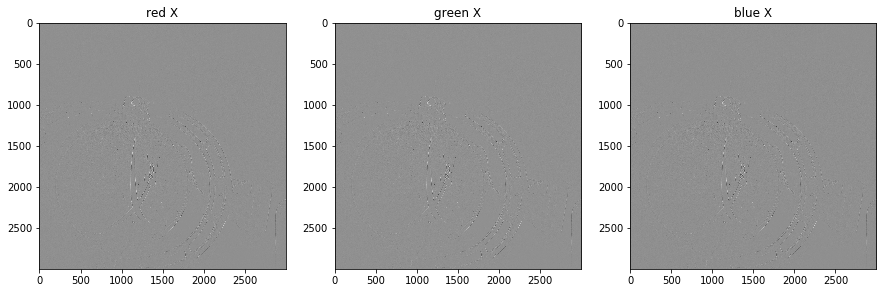

In [62]:
f, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].set_title("red X")
ax[1].set_title("green X")
ax[2].set_title("blue X")

for i, color in enumerate(cv2.split(sobelx)):
    ax[i].imshow(color, cmap='gray')

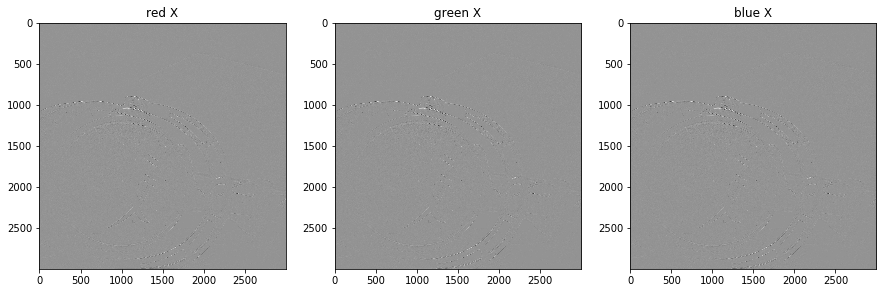

In [63]:
f, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].set_title("red X")
ax[1].set_title("green X")
ax[2].set_title("blue X")

for i, color in enumerate(cv2.split(sobely)):
    ax[i].imshow(color, cmap='gray')

### Solver

In [64]:
def calc_R(alpha, I, I_max):
    return alpha * I + (1 - alpha) * I_max

In [65]:
def solve_poisson(shape, div_G):
    A = pyamg.gallery.poisson(shape, format='csr')  # 2D Poisson problem on 500x500 grid
    ml = pyamg.ruge_stuben_solver(A)                    # construct the multigrid hierarchy
    print(ml)                                           # print hierarchy information
    b = div_G.ravel()
    x = ml.solve(b, tol=1e-10)
    print("residual: ", np.linalg.norm(b-A*x)) 
    return x

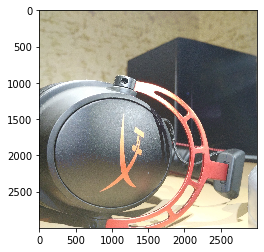

In [66]:
I_max = get_maximum(imgs)
plt.imshow(I_max)

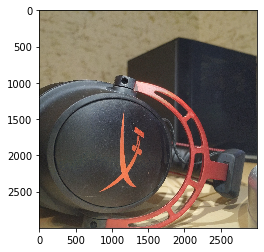

In [67]:
I_median = np.median(imgs, axis=0)
plt.imshow(I_median.astype('uint8'))

#### Full img

In [68]:
shape = imgs[0].shape
size = shape[0]

##### Sobel

multilevel_solver
Number of Levels:     10
Operator Complexity:  2.341
Grid Complexity:      1.573
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0     27000000    170964000 [42.72%]
    1     13500000    202404006 [50.57%]
    2      1538303     20845899 [ 5.21%]
    3       306605      4219445 [ 1.05%]
    4        78147      1179713 [ 0.29%]
    5        28700       406996 [ 0.10%]
    6        10896       133220 [ 0.03%]
    7         4050        39912 [ 0.01%]
    8         1457        11389 [ 0.00%]
    9          523         3405 [ 0.00%]

residual:  0.0003497933442410058


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ans: (dtype('float64'), (3000, 3000, 3), -553915.6517900449, 60.5024084092434, 397360.21195400646)
Wall time: 2min 14s


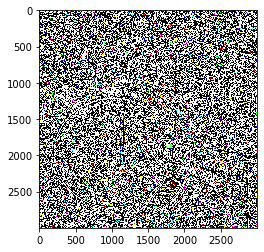

In [69]:
%%time
ans_sobel = solve_poisson(shape, div_G_sobel).reshape(-1, size, 3)
plt.imshow(ans_sobel)
print(f"ans: {stats(ans_sobel)}")

In [30]:
ans_sobel[1]

NameError: name 'ans_sobel' is not defined

#### By color img

In [70]:
shape = (size, size)

#### Sobel

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.203
Grid Complexity:      1.667
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0      9000000     44988000 [45.40%]
    1      4500000     40476002 [40.84%]
    2      1125002     10119644 [10.21%]
    3       280959      2584451 [ 2.61%]
    4        70308       690736 [ 0.70%]
    5        17442       179402 [ 0.18%]
    6         4348        45802 [ 0.05%]
    7         1069        11389 [ 0.01%]
    8          266         2970 [ 0.00%]
    9           66          716 [ 0.00%]

residual:  0.003625601574391474


D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.203
Grid Complexity:      1.667
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0      9000000     44988000 [45.40%]
    1      4500000     40476002 [40.84%]
    2      1125002     10119644 [10.21%]
    3       280959      2584451 [ 2.61%]
    4        70308       690736 [ 0.70%]
    5        17442       179402 [ 0.18%]
    6         4348        45802 [ 0.05%]
    7         1069        11389 [ 0.01%]
    8          266         2970 [ 0.00%]
    9           66          716 [ 0.00%]

residual:  0.004861987450209033


D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.203
Grid Complexity:      1.667
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0      9000000     44988000 [45.40%]
    1      4500000     40476002 [40.84%]
    2      1125002     10119644 [10.21%]
    3       280959      2584451 [ 2.61%]
    4        70308       690736 [ 0.70%]
    5        17442       179402 [ 0.18%]
    6         4348        45802 [ 0.05%]
    7         1069        11389 [ 0.01%]
    8          266         2970 [ 0.00%]
    9           66          716 [ 0.00%]

residual:  0.003635168539195858


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sobel by colors ans: (dtype('float64'), (3000, 3000, 3), -2084163.4365325903, 233581.31240985426, 1856592.0097589109)
Wall time: 2min 19s


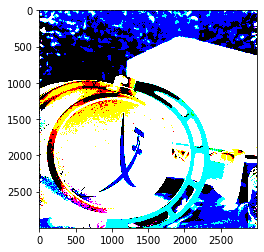

In [71]:
%%time
colors_sobel = cv2.split(div_G_sobel)
ans = []
for color in colors_sobel:
    ans.append(solve_poisson(shape, color).reshape(-1, size))
ans = cv2.merge(ans)
print(f"Sobel by colors ans: {stats(ans)}")
plt.imshow(ans)

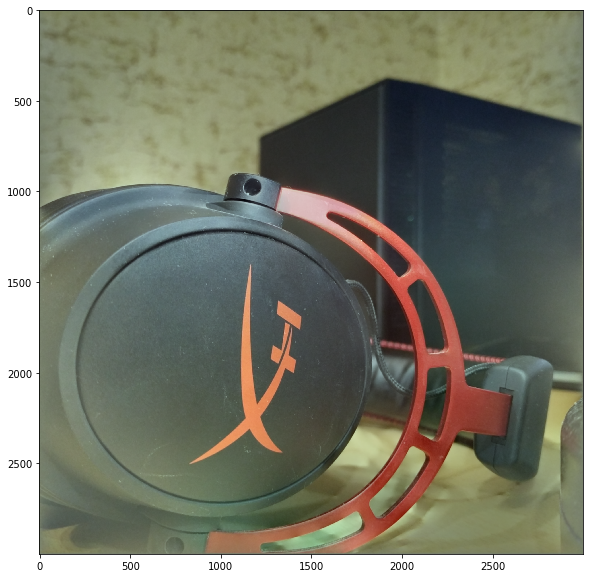

In [91]:
test = np.copy(-1 * ans)
colors = cv2.split(test)
result = []
for color in colors:
    color -= np.min(color)
    color /= np.max(color) / 255
    color[color > 255] = 255
    color = color.astype('uint8')
    result.append(color)
result = cv2.merge(result)

f, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(result)

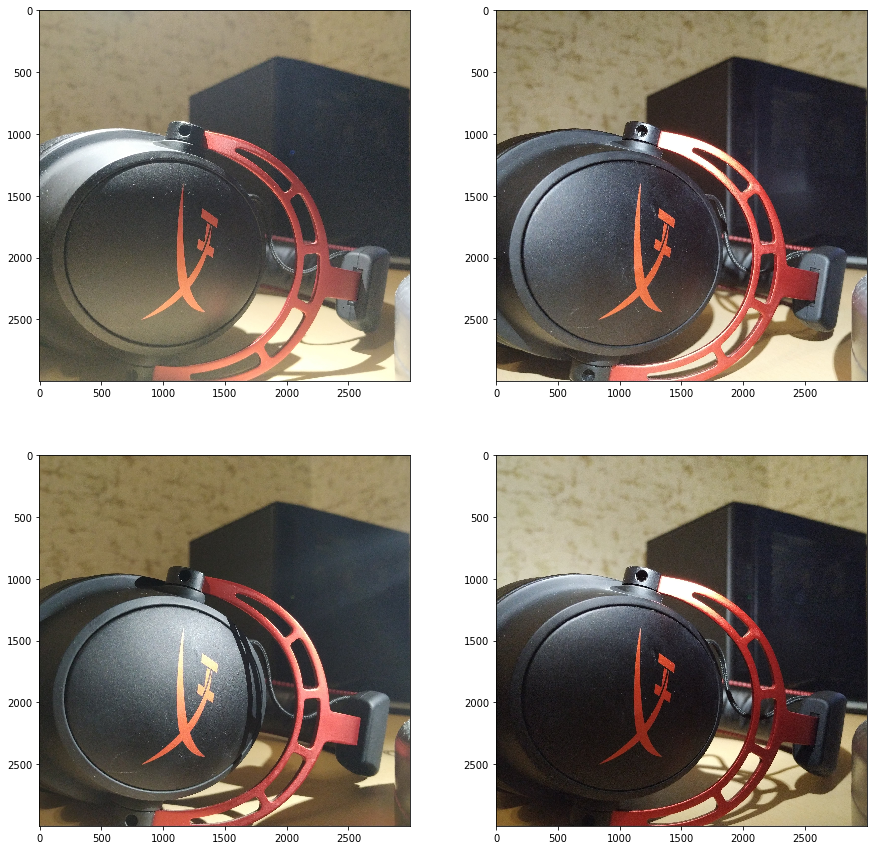

In [79]:
f, axarr = plt.subplots(2,2, figsize=(15,15))
axarr[0,0].imshow(imgs[0])
axarr[0,1].imshow(imgs[1])
axarr[1,0].imshow(imgs[2])
axarr[1,1].imshow(imgs[3])

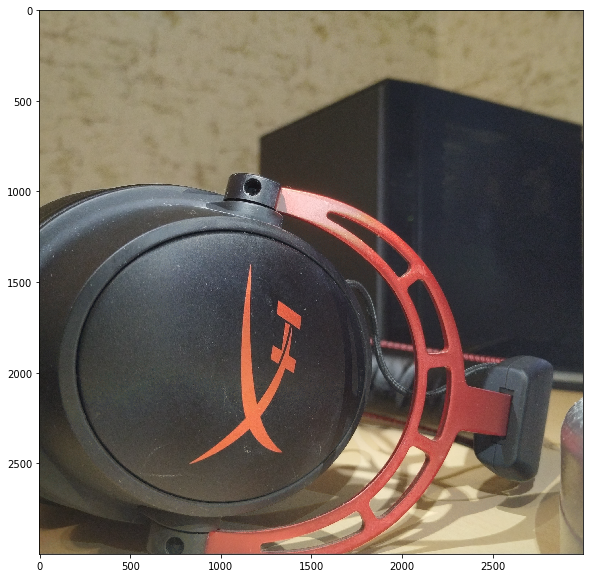

In [88]:
f, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(I_median.astype('uint8'))

R stats: (dtype('float64'), (3000, 3000, 3), 7.199999999999999, 105.6, 255.0)


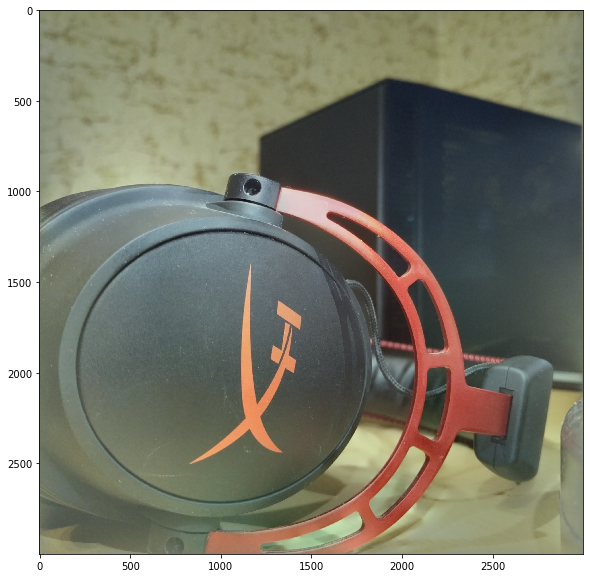

In [86]:
R = calc_R(0.8, result, I_max)
print(f"R stats: {stats(R)}")
f, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(R.astype('uint8'))
# plt.imshow(R.astype('uint8'))

In [134]:
def show_with_mask(img, mask):
    coef_indxs = np.copy(mask)
    coef_indxs[coef_indxs == True] = 1
    coef_indxs[coef_indxs == False] = 0
    _3d_coef_indxs = np.repeat(coef_indxs[:, :, np.newaxis], 3, axis=2)
    plt.imshow(img * _3d_coef_indxs)
alpha = 0.1
theta = 0.01
sigma = 0.01
B1 = 3
B2 = 0.1 

In [101]:
hsv_img = cv2.cvtColor(I_max, cv2.COLOR_RGB2HSV).astype('float32') / 255.0
H, S, V = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]

I_b, I_g, I_r = cv2.split(I_max)
I_gmd = np.minimum(I_b, I_g, I_r)

In [102]:
%%time
def check_bound(x, upper_bound):
    b1 = x - 1 > 0
    b2 = x + 1 < upper_bound
    return b1 and b2

G = np.copy(I_gmd)
for y in range(I_gmd.shape[0]):
    for x in range(I_gmd.shape[1]):
        if not check_bound(x, I_gmd.shape[1]) or  not check_bound(y, I_gmd.shape[0]):
            continue
        
        G[y, x] = np.sqrt( ( I_gmd[y, x+1] - I_gmd[y, x-1] ) ** 2  +  ( I_gmd[y+1, x] - I_gmd[y-1, x] ) ** 2 ) / 2

D:\anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  if sys.path[0] == '':


Wall time: 1min 15s


In [135]:
X_G = np.array(G >= theta)
X_SV = np.array(S < alpha) | np.array(V > (1 - alpha))

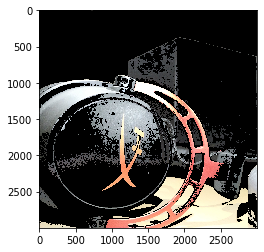

In [137]:
show_with_mask(I_max, X_SV)

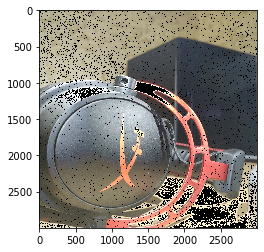

In [138]:
show_with_mask(I_max, X_G)

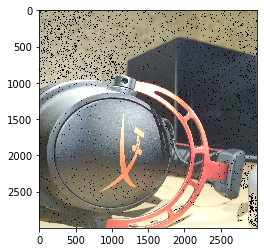

In [139]:
X_SVG = X_SV | X_G
show_with_mask(I_max, X_SVG)

In [108]:
stats(X_SVG)

(dtype('bool'), (3000, 3000), False, 1.0, True)

R stats: (dtype('uint8'), (3000, 3000, 3), 21, 128.0, 255)
Wall time: 580 ms


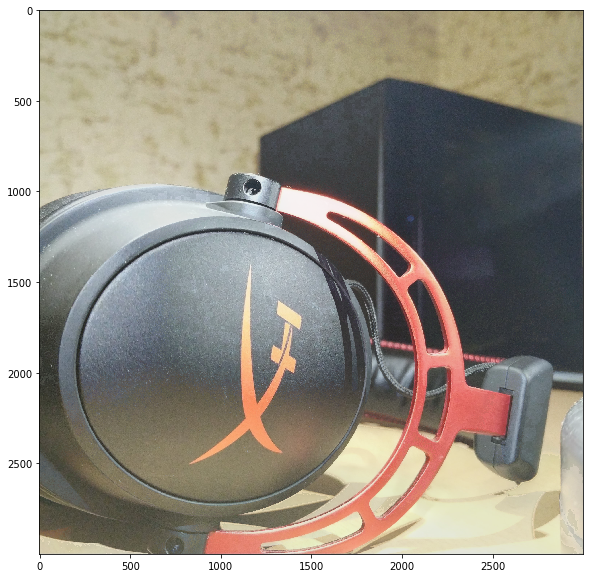

In [145]:
%%time
def calc_R_alpha_channel(alpha, I, I_max, alpha_channel):
    R = np.copy(I_max)
    R[alpha_channel] = alpha * I[alpha_channel] + (1 - alpha) * I_max[alpha_channel]
    return R

R2 = calc_R_alpha_channel(0.2, result, I_max, X_SV)
print(f"R stats: {stats(R2)}")

f, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(R2.astype('uint8'))
